In [1]:
"""import packages"""
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from math import pi
import functools

import tensorflow as tf
from tensorflow import keras
import app

import xlrd
from scipy.io import loadmat
import pandas as pd
import plot_boundary_on_data

In [2]:
"""global variables"""
BATCH_SIZE = 200   # number of training examples to use per training step

In [3]:
"""define flags usable from command line"""
tf.compat.v1.app.flags.DEFINE_string('f', '', 'kernel')
tf.compat.v1.app.flags.DEFINE_string('train', 'IQ_gstatefreq.csv',
                           'File containing the training data (labels & features).')
# note: change 'IQ_gstatefreq.csv' to 'IQ_maxdistfreq.csv' or 'IQ_difffreq.csv' for data at different frequencies
tf.compat.v1.app.flags.DEFINE_integer('num_epochs', 100,
                            'Number of training epochs.')
tf.compat.v1.app.flags.DEFINE_float('svmC', 10,
                            'The C parameter of the SVM cost function.')
tf.compat.v1.app.flags.DEFINE_boolean('verbose', False, 'Produce verbose output.')
tf.compat.v1.app.flags.DEFINE_boolean('plot', True, 'Plot the final decision boundary on the data.')
FLAGS = tf.compat.v1.app.flags.FLAGS

In [4]:
"""extract numpy representations of the labels and features given rows consisting of:
      label, feat_0, feat_1, ..., feat_n
   The given file should be a comma-separated-values (CSV) file saved by the savetxt command."""

def extract_data(filename):
    out = np.loadtxt(filename, delimiter=',');

    # arrays to hold the labels and feature vectors.
    labels = out[:,0]
    labels = labels.reshape(labels.size,1)
    fvecs = out[:,1:]

    # return a pair of the feature matrix and the one-hot label matrix.
    return fvecs,labels

In [5]:
def main(argv=None):
    # Be verbose?
    verbose = FLAGS.verbose

    # Plot? 
    plot = FLAGS.plot
    
    # Get the data.
    train_data_filename = FLAGS.train

    # Extract it into numpy matrices.
    train_data,train_labels = extract_data(train_data_filename)

    # Convert labels to +1,-1
    train_labels[train_labels==0] = -1

    # Get the shape of the training data.
    train_size,num_features = train_data.shape

    # Get the number of epochs for training.
    num_epochs = FLAGS.num_epochs

    # Get the C param of SVM
    svmC = FLAGS.svmC

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    tf.compat.v1.disable_eager_execution()
    x = tf.compat.v1.placeholder("float", shape=[None, num_features])
    y = tf.compat.v1.placeholder("float", shape=[None,1])

    # Define and initialize the network.

    # These are the weights that inform how much each feature contributes to
    # the classification.
    W = tf.Variable(tf.zeros([num_features,1]))
    b = tf.Variable(tf.zeros([1]))
    y_raw = tf.matmul(x,W) + b

    # Optimization.
    regularization_loss = 0.5*tf.reduce_sum(tf.square(W)) 
    hinge_loss = tf.reduce_sum(tf.maximum(tf.zeros([BATCH_SIZE,1]), 
        1 - y*y_raw));
    svm_loss = regularization_loss + svmC*hinge_loss;
    train_step = tf.compat.v1.train.GradientDescentOptimizer(0.01).minimize(svm_loss)

    # Evaluation.
    predicted_class = tf.sign(y_raw);
    correct_prediction = tf.equal(y,predicted_class)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    # Create a local session to run this computation.
    with tf.compat.v1.Session() as s:
        # Run all the initializers to prepare the trainable parameters.
        tf.compat.v1.initialize_all_variables().run()
        if verbose:
            print('Initialized!')
            print()
            print('Training.')

        # Iterate and train.
        for step in range(num_epochs * train_size // BATCH_SIZE):
            if verbose:
                print(step)
                
            offset = (step * BATCH_SIZE) % train_size
            batch_data = train_data[offset:(offset + BATCH_SIZE), :]
            batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
            train_step.run(feed_dict={x: batch_data, y: batch_labels})
            print('loss: ', svm_loss.eval(feed_dict={x: batch_data, y: batch_labels}))
            
            if verbose and offset >= train_size-BATCH_SIZE:
                print

        # Give very detailed output.
        if verbose:
            print()
            print('Weight matrix.')
            print(s.run(W))
            print()
            print('Bias vector.')
            print(s.run(b))
            print()
            print("Applying model to first test instance.")
            print()
            
        print("Accuracy on train:", accuracy.eval(feed_dict={x: train_data, y: train_labels}))

        if plot:
            eval_fun = lambda X: predicted_class.eval(feed_dict={x:X}); 
            plot_boundary_on_data.plot(train_data, train_labels, eval_fun)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
loss:  5208.484
loss:  5104.8354
loss:  11828.961
loss:  67451.81
loss:  30643.21
loss:  5786.7056
loss:  5671.55
loss:  5558.686
loss:  5448.0684
loss:  5339.6514
loss:  5434.8916
loss:  6161.9487
loss:  13339.946
loss:  78789.02
loss:  48522.043
loss:  6294.559
loss:  6169.298
loss:  6046.5283
loss:  5926.2026
loss:  5808.2715
loss:  5279.7603
loss:  5633.3247
loss:  10230.515
loss:  55004.184
loss:  26212.17
loss:  2779.2153
loss:  2723.9092
loss:  2669.7034
loss:  2616.5764
loss:  2564.5063
loss:  2630.6636
loss:  2578.3132
loss:  3335.7605
loss:  12321.432
loss:  143.74414
loss:  14337.152
loss:  14051.843
loss:  13772.211
loss:  13498.145
loss:  13229.532
loss:  35803.31
loss:  15695.156
loss:  18449.58
loss:  57824.227
loss:  59438.125
loss:  2011.1942
loss:  1971.1715
loss:  1931.9452
loss:  1893.4995
loss:  1855.8188
loss:  2185.5244
loss:  1667.66
loss:  2056.832
loss:  3146.2444
loss:  672.091
loss:  9

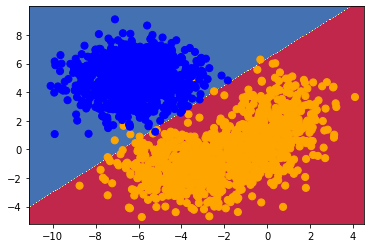

In [6]:
main()